In [173]:
options(repr.plot.width = 20, repr.plot.height = 20)

In [1]:
library(tidyverse)
library(rstatix)
library(ggplot2)
library(hrbrthemes)
library(irr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attache Paket: ‘rstatix’


Das folgende Objekt ist maskiert ‘package:stats’:

    filter


Lade nötiges Paket: lpSolve



In [2]:
t_fast <- read.table('/home/ibrazug/Dokumente/KindersegV2/Ibra/derivatives/FASTSURFER_SEG/fastsurfer_vol_abs.csv', sep=',', header=T) %>%
gather(key='ROI', value='vol_free', -IDs)
t_fast %>% head()

,IDs,ROI,vol_free
,<chr>,<chr>,<dbl>
1,sub-k10010,eTIV,1591678
2,sub-k10020,eTIV,1674340
3,sub-k10030,eTIV,1452211
4,sub-k10040,eTIV,1576846
5,sub-k10050,eTIV,1537468
6,sub-k10070,eTIV,1714574


In [3]:
t_free <- read.table('/home/ibrazug/Dokumente/KindersegV2/Ibra/derivatives/FREESURFER_SEG/freesurfer_vol_abs.csv', sep=',', header=T) %>%
mutate(IDs = gsub('([0-9a-zA-Z_-]*).reconall','\\1', IDs)) %>%
gather(key='ROI', value='vol_fast', -IDs)

t_free %>% head()

,IDs,ROI,vol_fast
,<chr>,<chr>,<dbl>
1,sub-k10010,eTIV,1599818
2,sub-k10020,eTIV,1675751
3,sub-k10030,eTIV,1463188
4,sub-k10040,eTIV,1587718
5,sub-k10050,eTIV,1613329
6,sub-k10070,eTIV,1719547


In [4]:
res = T
for (i in t_free$ROI %>% unique()) {
    res & (i %in% (t_free$ROI %>% unique()))
    }

In [5]:
res

[1] TRUE

In [6]:
data <- merge(t_free, t_fast, by=c('IDs', 'ROI'))

In [180]:
qc <- read.table('/home/ibrazug/Dokumente/KindersegV2/Ibra/derivatives/QC_SC_RESULT.csv', sep=',', header=T) %>%
select(c(subject, qc_inclusion)) %>% rename(IDs = subject)

In [183]:
data <- merge(data,
              qc,
              by='IDs') %>% filter(qc_inclusion == 'yes') %>% select(-qc_inclusion)

In [184]:
data %>% head()

,IDs,ROI,vol_fast,vol_free
,<chr>,<chr>,<dbl>,<dbl>
1,sub-k10010,BasalGanglia,50400.0,52386.4
2,sub-k10010,Brainstem,38393.6,40273.8
3,sub-k10010,Cerebellum,304943.2,308272.4
4,sub-k10010,Cingulate,52509.2,57639.4
5,sub-k10010,CorpusCallosum,7070.6,7396.4
6,sub-k10010,eTIV,1599818.0,1591678.0


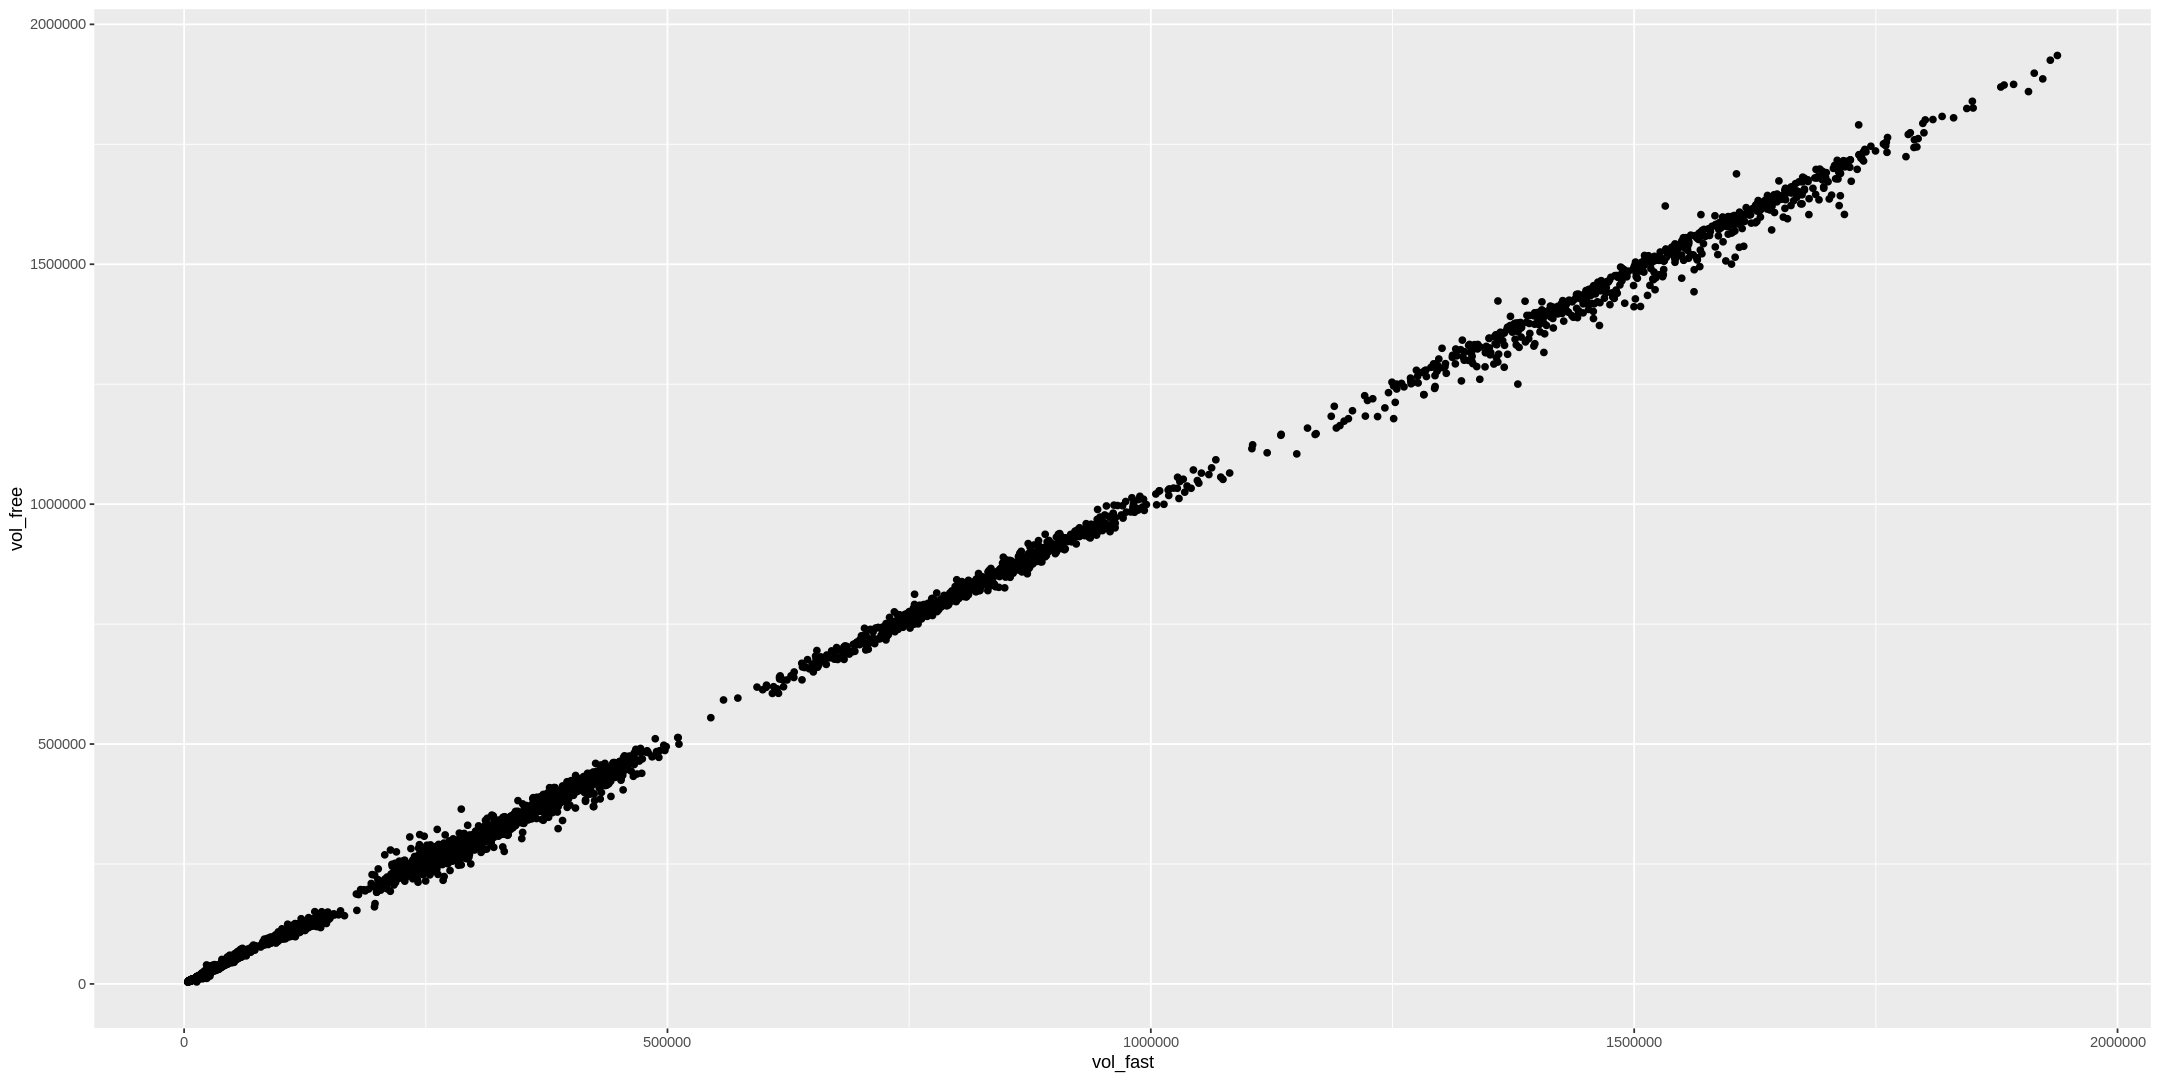

In [197]:
data %>%
ggplot(aes(x=vol_fast, y=vol_free)) +
geom_jitter()

In [9]:
sd

function (x, na.rm = FALSE) 
sqrt(var(if (is.vector(x) || is.factor(x)) x else as.double(x), 
    na.rm = na.rm))
<bytecode: 0x560f370c4cf8>
<environment: namespace:stats>

In [196]:
options(repr.plot.width = 18, repr.plot.height = 9)


In [11]:
data %>%
group_by(ROI) %>%
summarize(consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
         agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
         mean_vol = mean((vol_fast + vol_free)/2, na.rm=T),
         lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
         uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound)  %>%
gather(key='key', value='icc', -c(mean_vol,ROI, lCI, uCI)) %>%
filter(key=='agreement') %>%
arrange(icc) %>%
mutate(ROI=fct_reorder(ROI,icc)) %>% 
mutate(rating = ifelse(icc>=0.75, 'excellent', ifelse(icc>=0.6, 'good', ifelse(icc>=0.4, 'fair', 'poor'))))%>%
mutate(rating=factor(rating, levels=c('poor', 'fair', 'good', 'excellent')))%>%
mutate(labels=ifelse(icc<0.5,as.character(ROI),'')) 

ROI,mean_vol,lCI,uCI,key,icc,rating,labels
<fct>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<fct>,<chr>
Frontal_Parietal,17534.331,0.094332931,0.7515998,agreement,0.5438870,fair,
CorpusCallosum,6870.082,0.018880391,0.9113089,agreement,0.7540765,excellent,
Insula,28043.424,0.158927572,0.9069978,agreement,0.7680702,excellent,
BasalGanglia,47793.802,0.007542584,0.9560609,agreement,0.8516435,excellent,
Cingulate,53478.996,0.269671720,0.9486039,agreement,0.8584979,excellent,
Parietal,271471.793,0.876563544,0.9073490,agreement,0.8929961,excellent,
VentralDC,15487.738,0.756624732,0.9473749,agreement,0.9003072,excellent,
Occipital,115167.489,0.889738893,0.9367685,agreement,0.9175842,excellent,
Thalamus,29886.116,0.917225842,0.9397121,agreement,0.9293949,excellent,


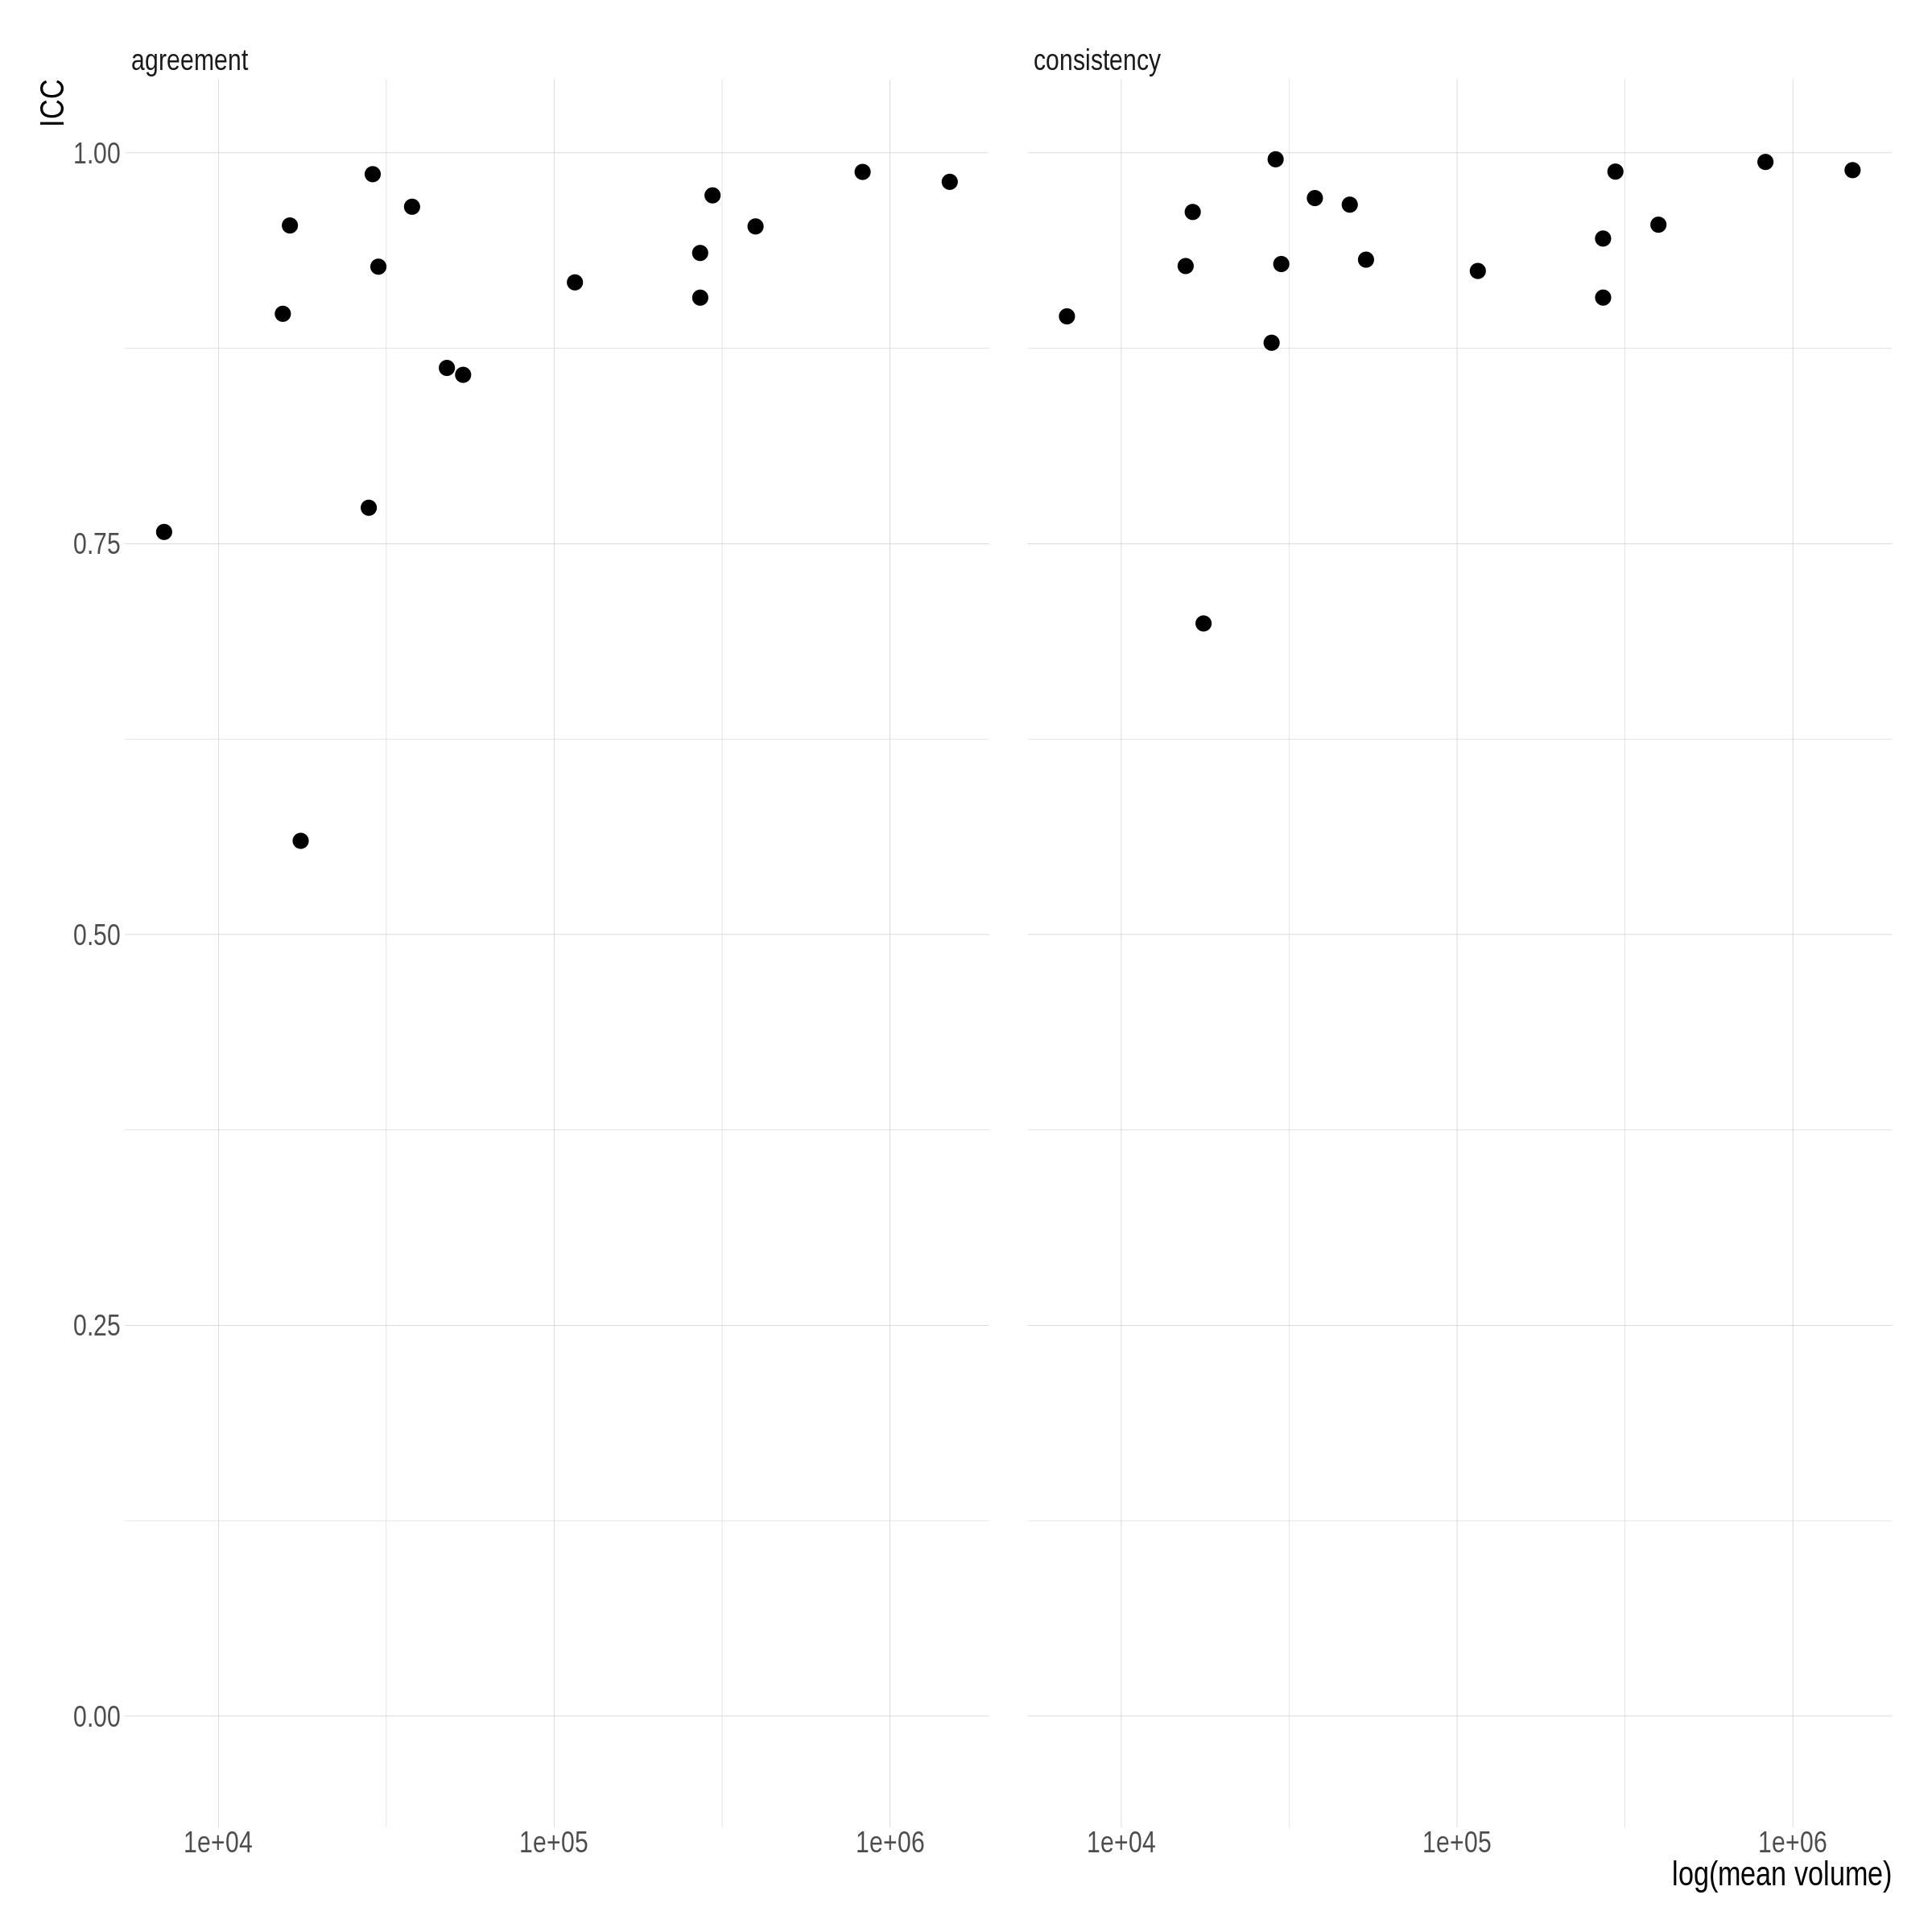

In [193]:
data %>%
group_by(ROI) %>%
summarize(consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
         agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
         mean_vol = mean((vol_fast + vol_free)/2, na.rm=T),
         lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
         uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound)  %>%
gather(key='key', value='icc', -c(mean_vol,ROI, lCI, uCI)) %>%
arrange(icc) %>%
mutate(ROI=fct_reorder(ROI,icc)) %>% 
mutate(rating = ifelse(icc>=0.75, 'excellent', ifelse(icc>=0.6, 'good', ifelse(icc>=0.4, 'fair', 'poor'))))%>%
mutate(rating=factor(rating, levels=c('poor', 'fair', 'good', 'excellent')))%>%
mutate(labels=ifelse(icc<0.5,as.character(ROI),''))  %>%
ggplot(aes(x=mean_vol, y=icc, ymin = lCI, ymax = uCI, label=labels))+
#geom_errorbar(width = 0.1, alpha=0.1)+
#geom_label(size=5)+
geom_jitter(size=5)+
#stat_smooth(method='auto')+
scale_x_continuous(trans='log10')+
labs(x='log(mean volume)', y='ICC')+
theme_ipsum()+
scale_color_ipsum()+
    theme(axis.title.x=element_text(size=25),
     axis.title.y=element_text(size=25),
     strip.text = element_text(size = 22),
     axis.text.x = element_text(size=22),
     axis.text.y = element_text(size=22),
    legend.title = element_text(size=22),
    legend.text = element_text(size=22)
     )+
facet_wrap(~key)

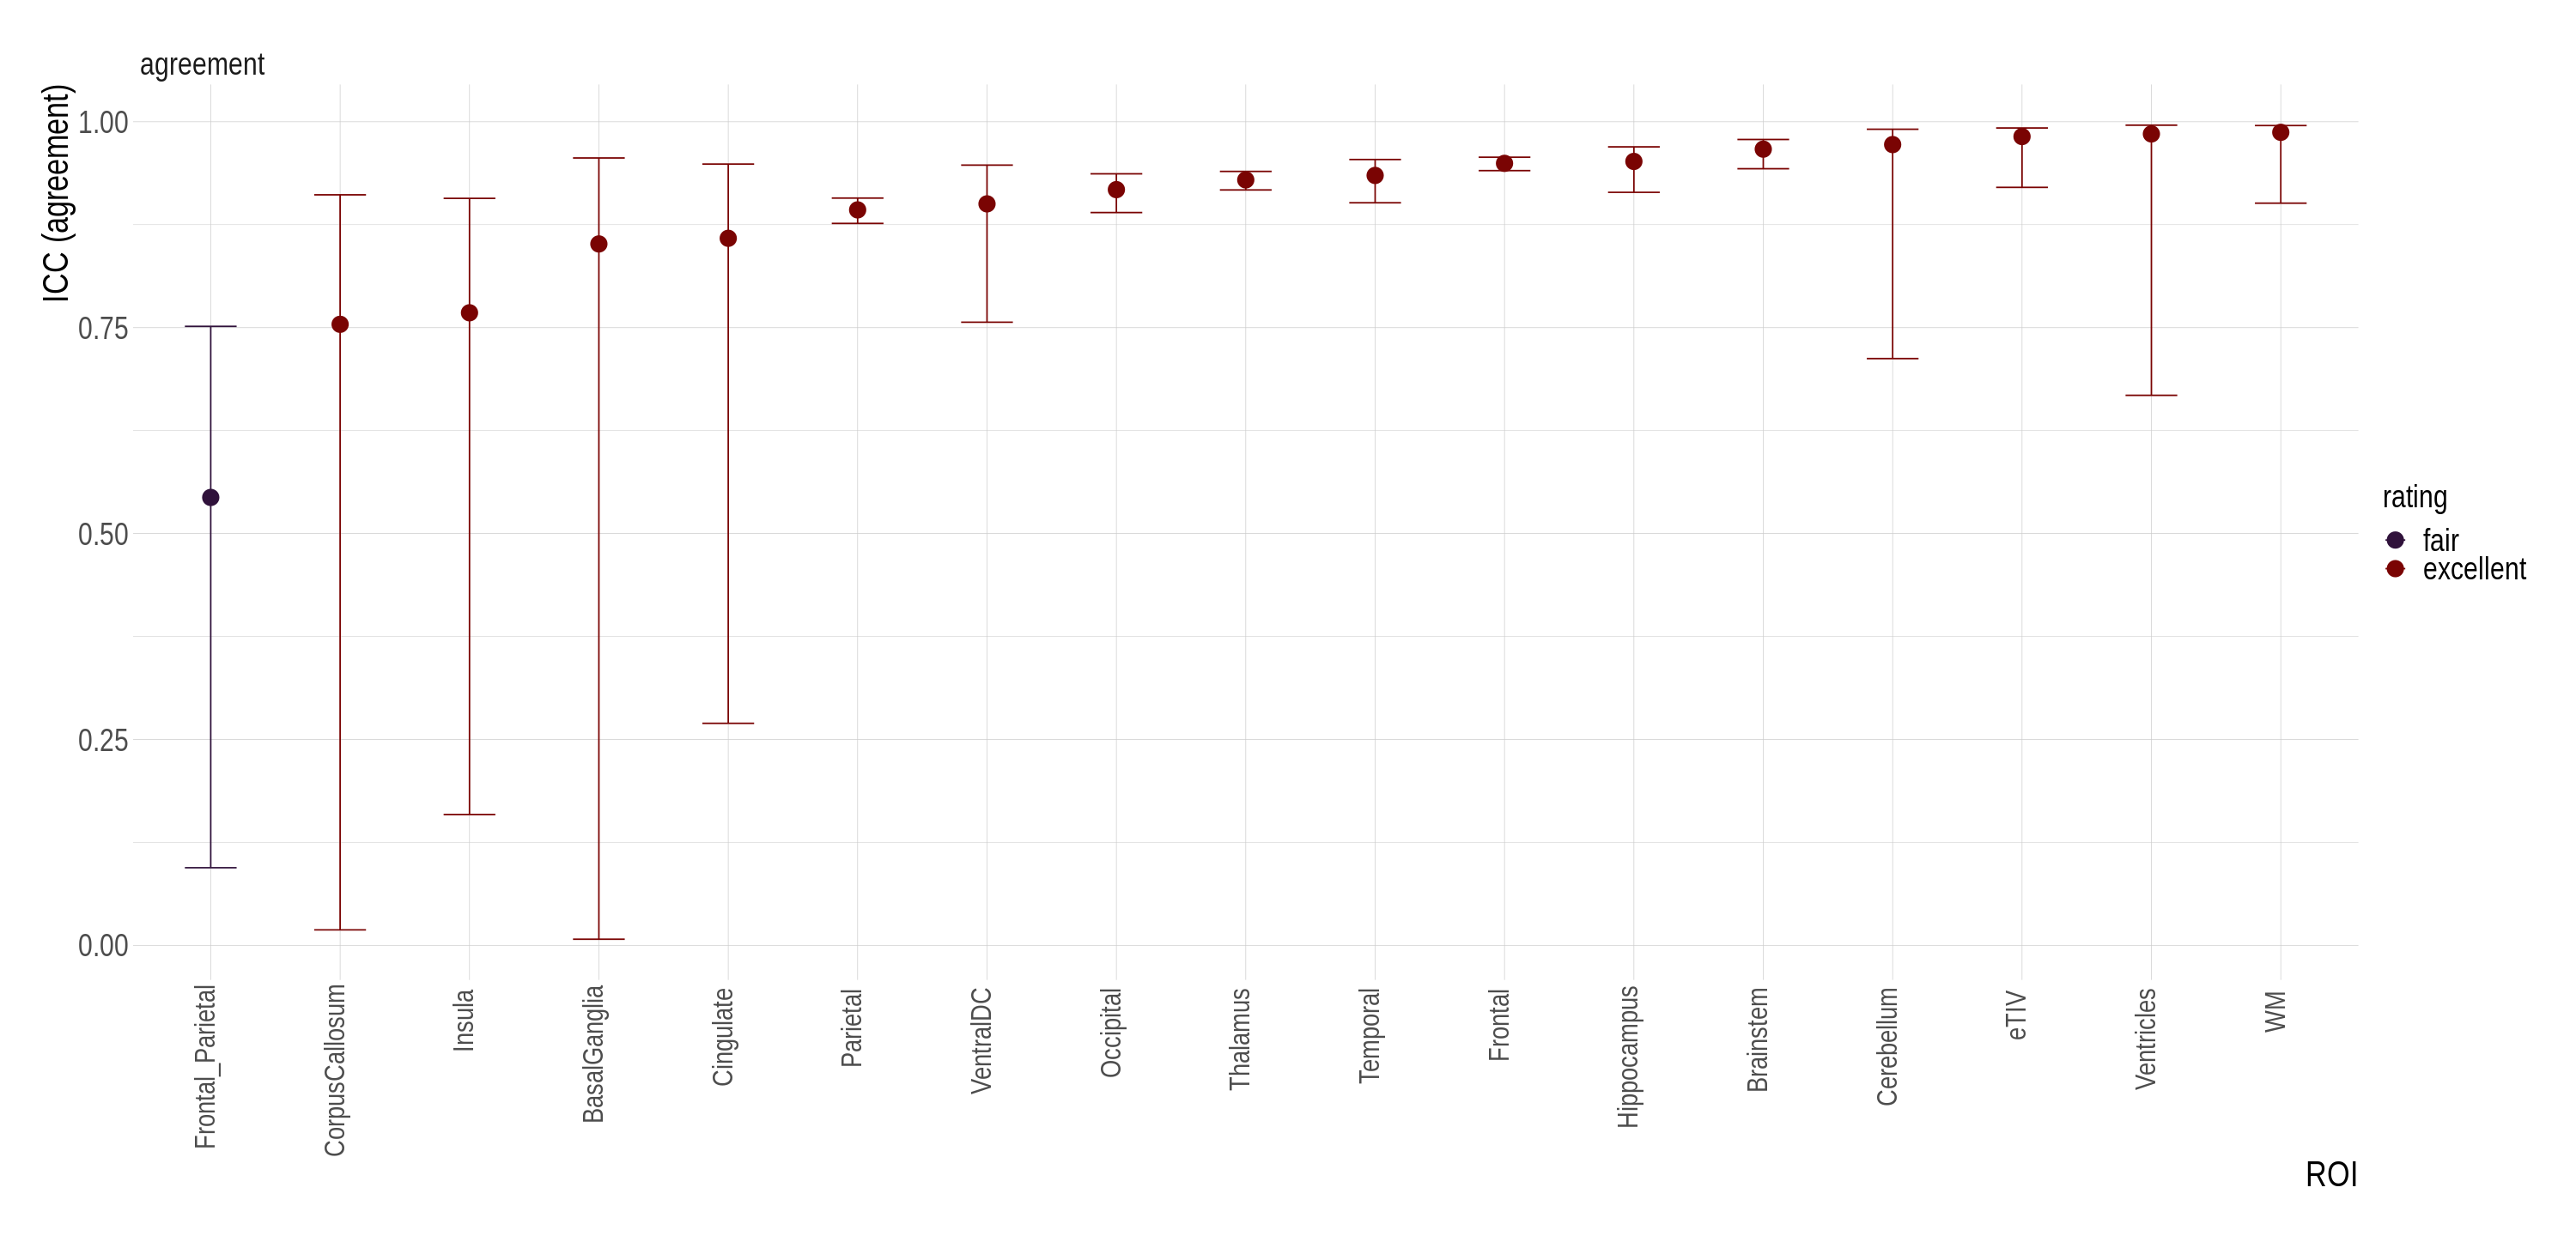

In [14]:
data %>%
group_by(ROI) %>%
summarize(consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
         agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
         mean_vol = mean((vol_fast + vol_free)/2, na.rm=T),
         lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
         uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound)  %>%
gather(key='key', value='icc', -c(mean_vol,ROI, lCI, uCI)) %>%
filter(key=='agreement') %>%
arrange(icc) %>%
mutate(ROI=fct_reorder(ROI,icc)) %>% 
mutate(rating = ifelse(icc>=0.75, 'excellent', ifelse(icc>=0.6, 'good', ifelse(icc>=0.4, 'fair', 'poor'))))%>%
mutate(rating=factor(rating, levels=c('poor', 'fair', 'good', 'excellent')))%>%
ggplot(aes(x=ROI, y=icc, ymin = lCI, ymax = uCI, color=rating))+
#geom_bar(stat = "identity", alpha=0.1)+
geom_errorbar(width = 0.4)+
geom_point(size=5)+
#stat_smooth(method='auto')+
#scale_x_continuous(trans='log10')+
#scale_y_continuous("",label=scales::percent)+
labs(x='ROI', y='ICC (agreement)')+
theme_ipsum()+
scale_color_viridis_d(option='turbo')+
    theme(axis.title.x=element_text(size=25),
     axis.title.y=element_text(size=25),
     strip.text = element_text(size = 22),
     axis.text.x = element_text(size=20, angle=90,hjust=0.95,vjust=0.2),
     axis.text.y = element_text(size=22),
    legend.title = element_text(size=22),
    legend.text = element_text(size=22)
     )+
facet_wrap(~key)

In [15]:
vol_fast

ERROR: Error in eval(expr, envir, enclos): Objekt 'vol_fast' nicht gefunden


In [14]:
data %>%
group_by(ROI) %>%
summarize(consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
         agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
         mean_vol = mean((vol_fast + vol_free)/2, na.rm=T),
         lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
         uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound)  %>%
filter(agreement < 0.5)

ROI,consistency,agreement,mean_vol,lCI,uCI
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


In [15]:
icc(cbind(data$vol_fast, data$vol_free), "twoway", 'agreement')

 Single Score Intraclass Correlation

   Model: twoway 
   Type : agreement 

   Subjects = 11407 
     Raters = 2 
   ICC(A,1) = 1

 F-Test, H0: r0 = 0 ; H1: r0 > 0 
F(11406,10825) = 5379 , p = 0 

 95%-Confidence Interval for ICC Population Values:
  1 < ICC < 1

In [16]:
data %>%
group_by(ROI) %>%
summarize(consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
         agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
         mean_vol = mean((vol_fast + vol_free)/2, na.rm=T),
         lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
         uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound)  %>%
gather(key='key', value='icc', -c(mean_vol,ROI, lCI, uCI)) %>%
filter(key=='agreement') %>%
arrange(icc)

ROI,mean_vol,lCI,uCI,key,icc
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
Frontal_Parietal,17534.331,0.094332931,0.7515998,agreement,0.5438870
CorpusCallosum,6870.082,0.018880391,0.9113089,agreement,0.7540765
Insula,28043.424,0.158927572,0.9069978,agreement,0.7680702
BasalGanglia,47793.802,0.007542584,0.9560609,agreement,0.8516435
Cingulate,53478.996,0.269671720,0.9486039,agreement,0.8584979
Parietal,271471.793,0.876563544,0.9073490,agreement,0.8929961
VentralDC,15487.738,0.756624732,0.9473749,agreement,0.9003072
Occipital,115167.489,0.889738893,0.9367685,agreement,0.9175842
Thalamus,29886.116,0.917225842,0.9397121,agreement,0.9293949


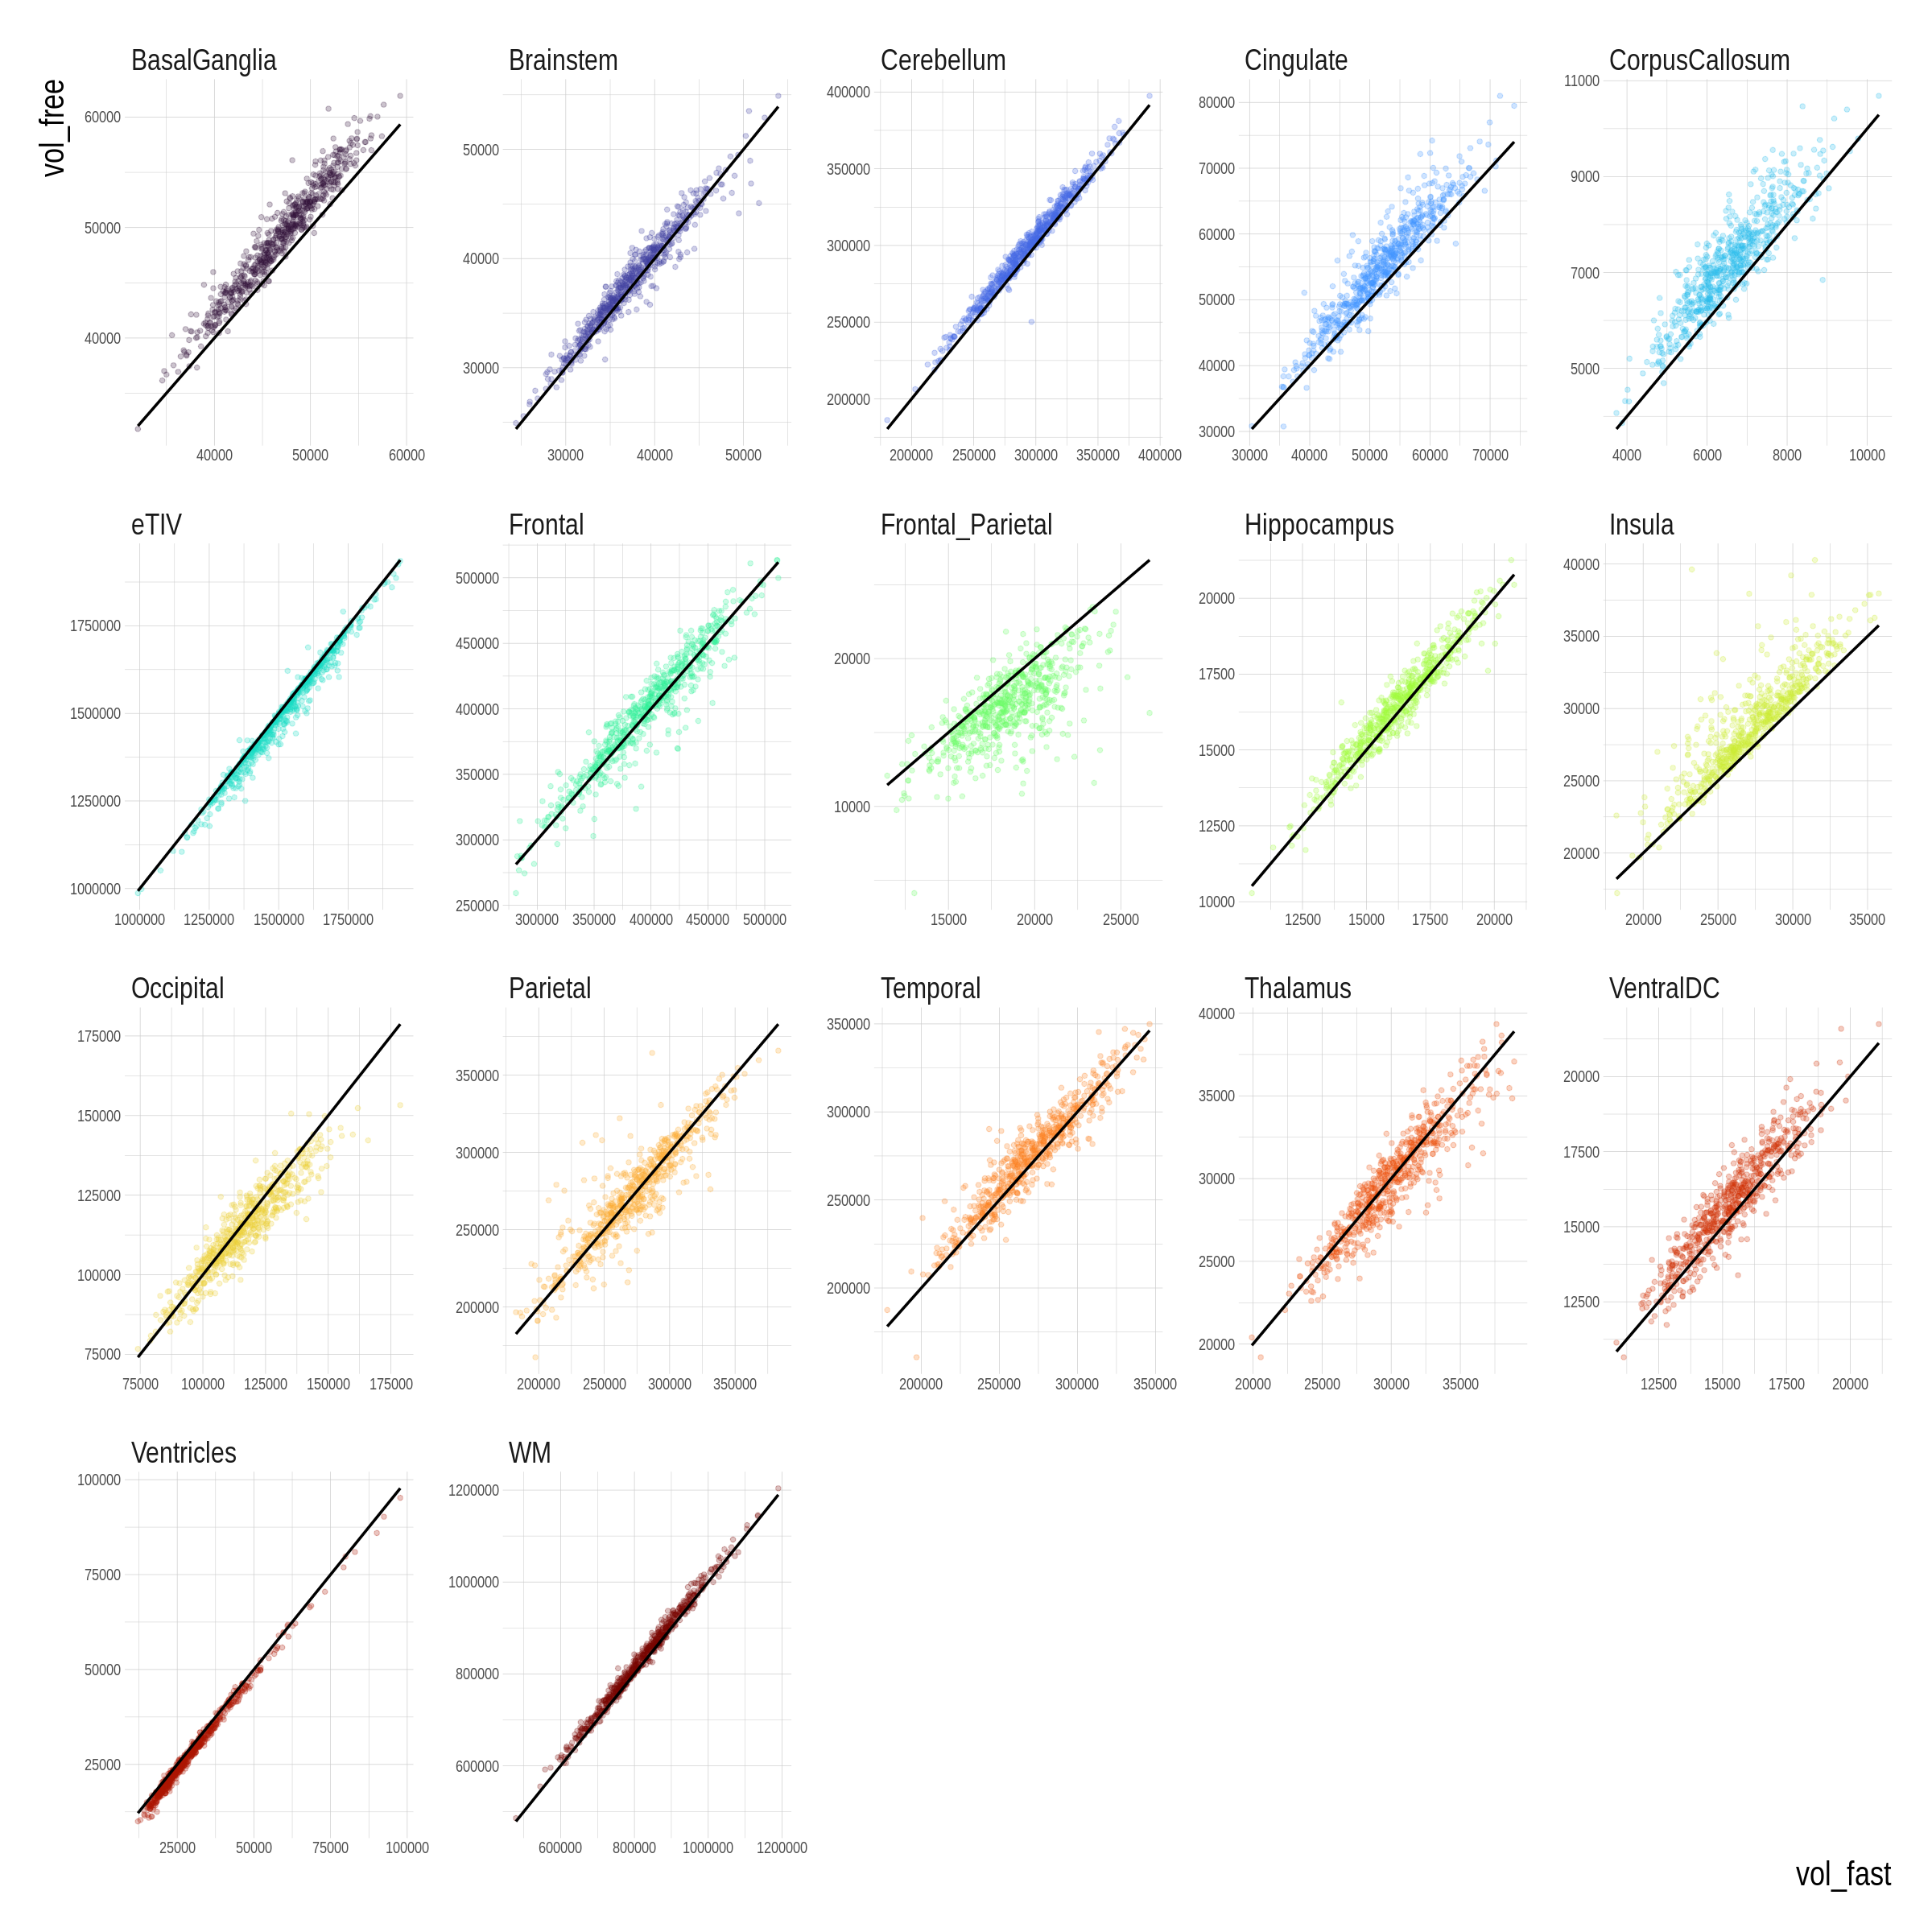

In [188]:
data %>%
ggplot(aes(x=vol_fast, y=vol_free, color=ROI))+
geom_point(alpha = 0.25) +
#geom_jitter()+
facet_wrap(~ROI, scales='free')+
stat_function(fun = function(x) x, color = "black" , size=1) +


theme_ipsum()+
scale_color_viridis_d(option='turbo')+
    theme(axis.title.x=element_text(size=25),
     axis.title.y=element_text(size=25),
     strip.text = element_text(size = 22),
     axis.text.x = element_text(size=12),#, angle=90,hjust=0.95,vjust=0.2),
     axis.text.y = element_text(size=12),
    legend.title = element_text(size=22),
    legend.text = element_text(size=22),
    legend.position='none'
     )

In [189]:
ggsave("/home/ibrazug/Dokumente/KindersegV2/Graphs/plot.jpeg", plot = last_plot(), width = 20, height = 17, dpi = 300)

In [27]:
data %>%
  group_by(ROI) %>%
  summarize(
    consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
    agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
    lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
    uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound
  ) %>%
  gather(key = 'key', value = 'icc', -c(ROI, lCI, uCI)) %>%
  filter(key == 'agreement')  %>%
  arrange(icc)

ROI,lCI,uCI,key,icc
<chr>,<dbl>,<dbl>,<chr>,<dbl>
Frontal_Parietal,0.094332931,0.7515998,agreement,0.5438870
CorpusCallosum,0.018880391,0.9113089,agreement,0.7540765
Insula,0.158927572,0.9069978,agreement,0.7680702
BasalGanglia,0.007542584,0.9560609,agreement,0.8516435
Cingulate,0.269671720,0.9486039,agreement,0.8584979
Parietal,0.876563544,0.9073490,agreement,0.8929961
VentralDC,0.756624732,0.9473749,agreement,0.9003072
Occipital,0.889738893,0.9367685,agreement,0.9175842
Thalamus,0.917225842,0.9397121,agreement,0.9293949


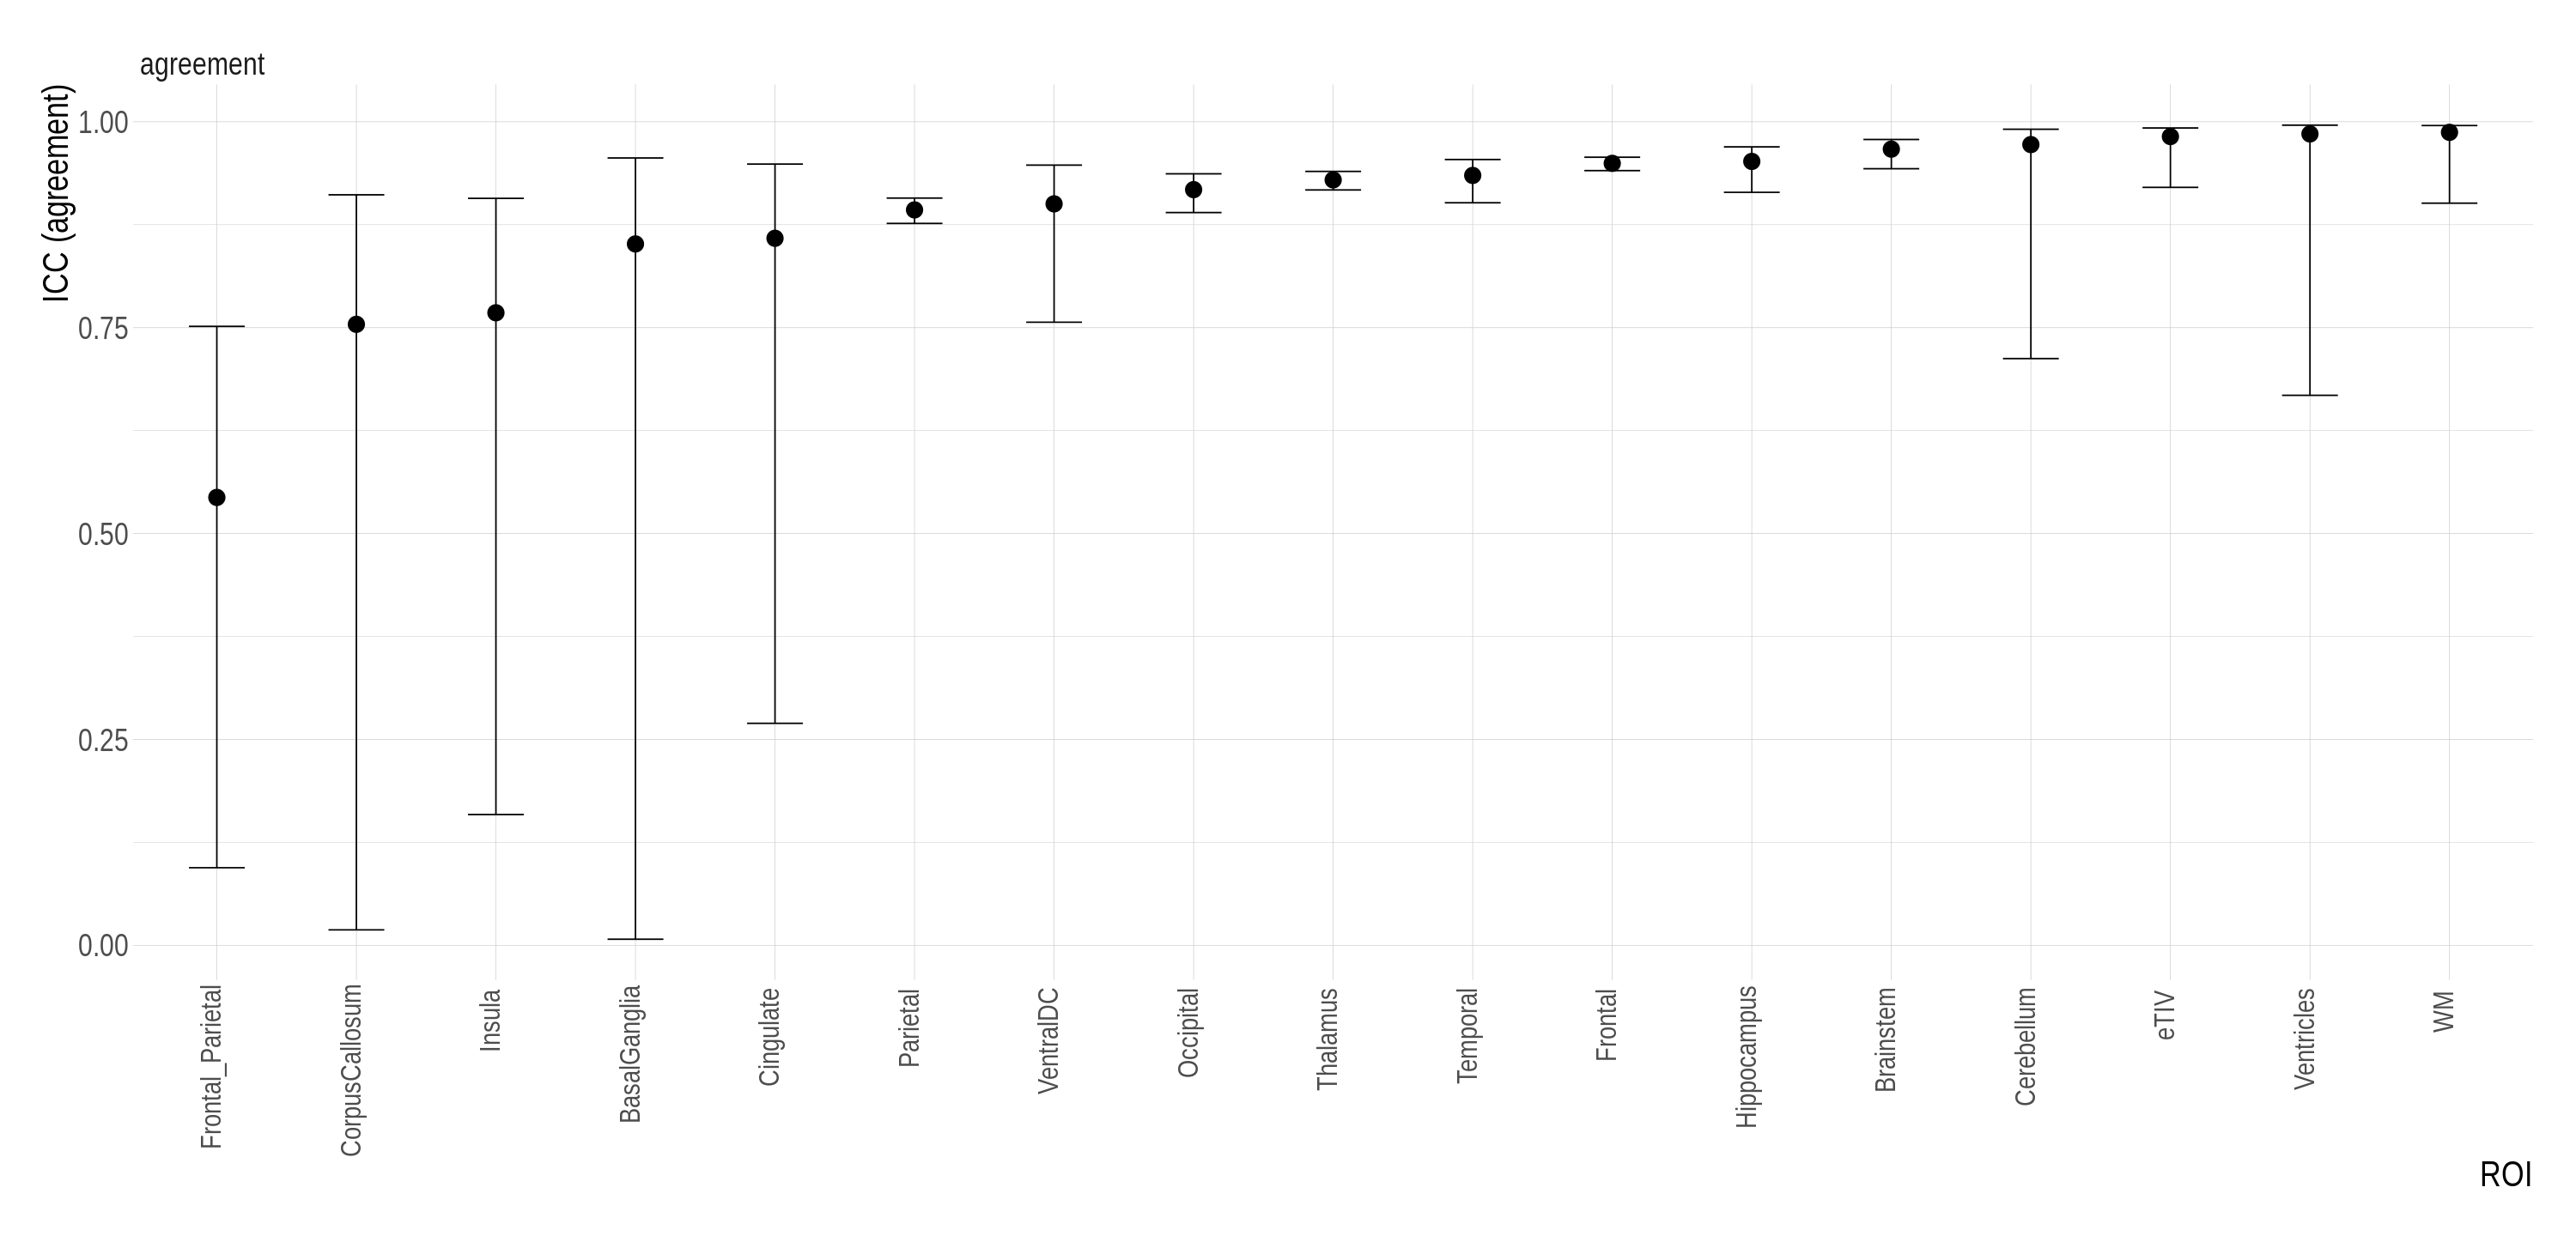

In [44]:
data %>%
  group_by(ROI) %>%
  summarize(
    consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
    agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
    lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
    uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound
  ) %>%
  gather(key = 'key', value = 'icc', -c(ROI, lCI, uCI)) %>%
  filter(key == 'agreement') %>%
  arrange(icc) %>%
  mutate(ROI = fct_reorder(ROI, icc)) %>% 
  
  ggplot(aes(x = ROI, y = icc, ymin = lCI, ymax = uCI)) +
  geom_errorbar(width = 0.4) +
  geom_point(size = 5) +
  labs(x = 'ROI', y = 'ICC (agreement)') +
  theme_ipsum() +
  scale_color_viridis_d(option = 'turbo') +
  theme(
    axis.title.x = element_text(size = 25),
    axis.title.y = element_text(size = 25),
    strip.text = element_text(size = 22),
    axis.text.x = element_text(size = 20, angle = 90, hjust = 0.95, vjust = 0.2),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 22),
    legend.text = element_text(size = 22)
  ) +
  facet_wrap(~ key)


In [74]:
#IBRA

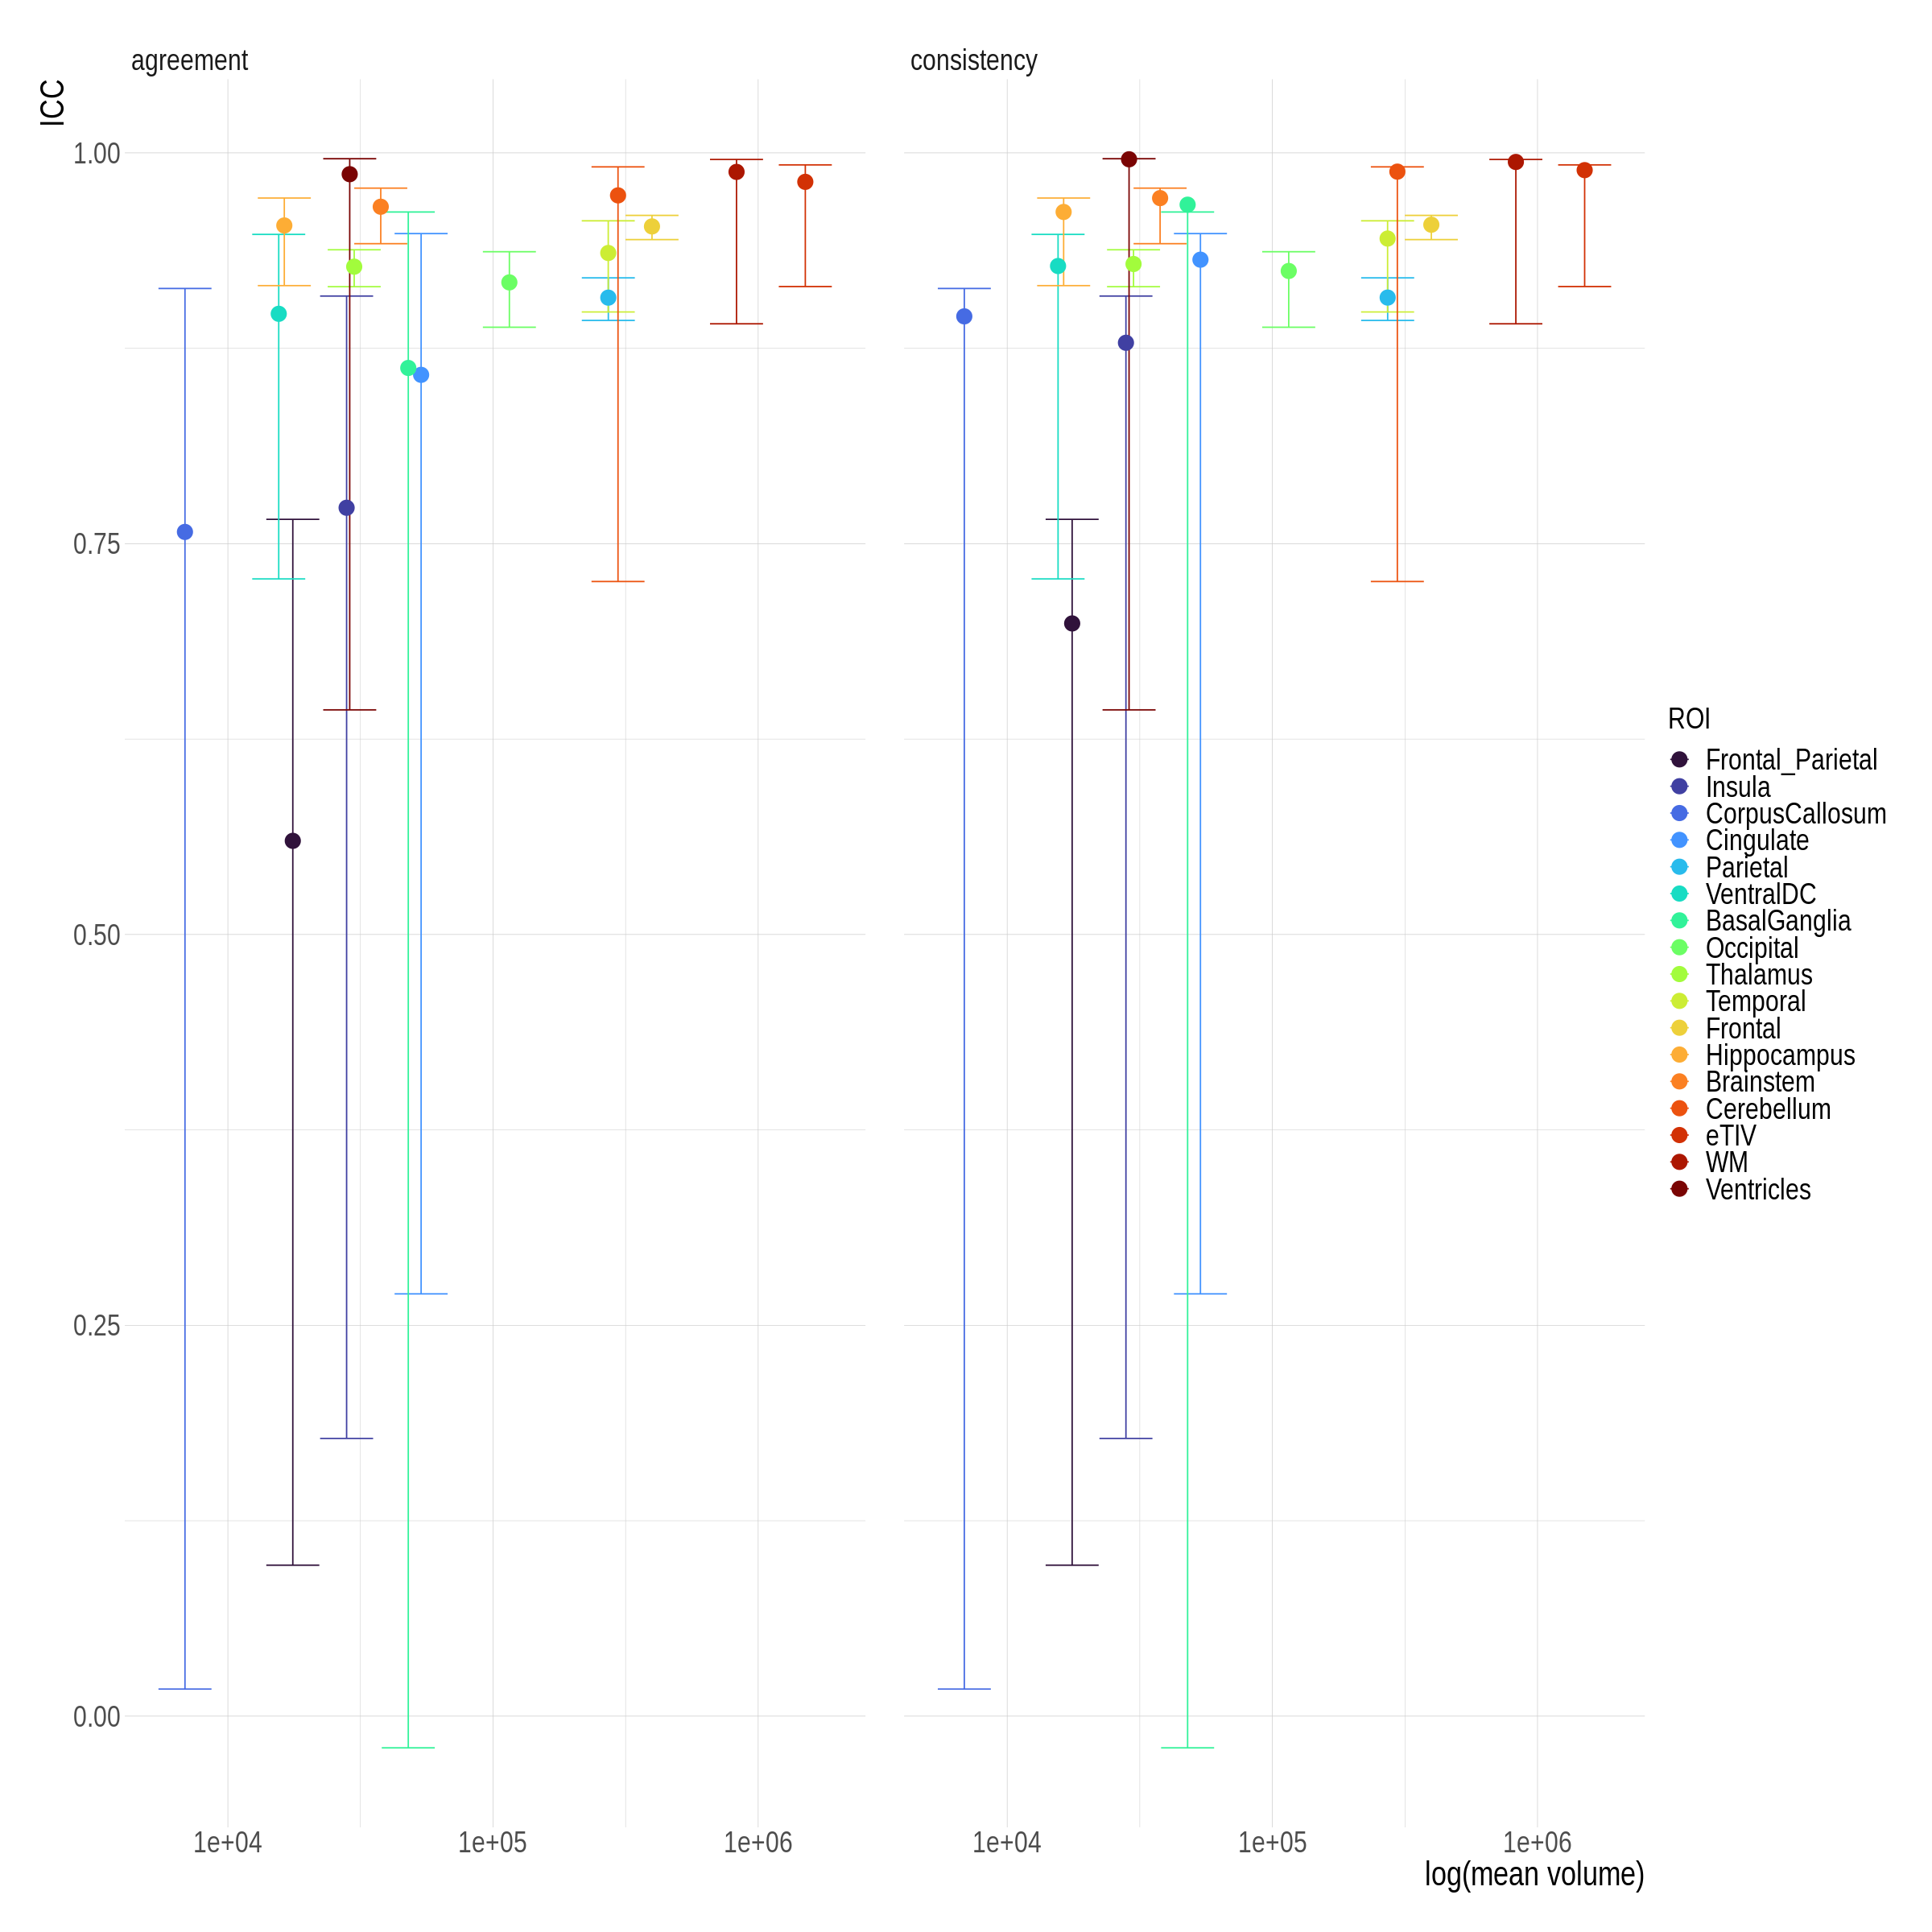

In [194]:
library(ggplot2)
library(dplyr)
library(tidyr)


data %>%
  group_by(ROI) %>%
  summarize(
    consistency = icc(cbind(vol_fast, vol_free), "twoway")$value,
    agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$value,
    mean_vol = mean((vol_fast + vol_free) / 2, na.rm = TRUE),
    lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$lbound,
    uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement')$ubound
  ) %>%
  gather(key = 'key', value = 'icc', -c(mean_vol, ROI, lCI, uCI)) %>%
  arrange(icc) %>%
  mutate(ROI = fct_reorder(ROI, icc)) %>%

  mutate(labels = ifelse(icc < 0.5, as.character(ROI), '')) %>%
  ggplot(aes(x = mean_vol, y = icc, ymin = lCI, ymax = uCI, label = labels, color = ROI)) +
  geom_errorbar(width = 0.2) +
  geom_point(size = 2) +
  geom_jitter(size = 5) +
  scale_x_continuous(trans = 'log10') +
  labs(x = 'log(mean volume)', y = 'ICC') +
  scale_color_viridis_d(option = "turbo")+
  theme_ipsum() +
  theme(
    axis.title.x = element_text(size = 25),
    axis.title.y = element_text(size = 25),
    strip.text = element_text(size = 22),
    axis.text.x = element_text(size = 22),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 22),
    legend.text = element_text(size = 22)
  ) +
  facet_wrap(~key)


In [96]:
#IGNORE CONSISTENCY ADD CONF INTER

In [138]:
confidence_level <- 0.9  # Set your desired confidence level here

data %>%
  group_by(ROI) %>%
  summarize(
    agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$value,
    mean_vol = mean((vol_fast + vol_free) / 2, na.rm = TRUE),
    lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$lbound,
    uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$ubound
  ) %>%
  gather(key = 'key', value = 'icc', -c(mean_vol, ROI, lCI, uCI)) %>%
  arrange(mean_vol) 

ROI,mean_vol,lCI,uCI,key,icc
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
CorpusCallosum,6870.082,0.1358334,0.8948643,agreement,0.7540765
VentralDC,15487.738,0.7895054,0.9417488,agreement,0.9003072
Hippocampus,16288.586,0.9220705,0.9672358,agreement,0.9518332
Frontal_Parietal,17534.331,0.1702890,0.7246687,agreement,0.5438870
Insula,28043.424,0.2794581,0.8919188,agreement,0.7680702
Ventricles,28750.888,0.8005775,0.9949048,agreement,0.9852258
Thalamus,29886.116,0.9193139,0.9381585,agreement,0.9293949
Brainstem,37564.009,0.9478412,0.9769393,agreement,0.9667571
BasalGanglia,47793.802,0.1359842,0.9462722,agreement,0.8516435


In [120]:
ggsave("/home/ibrazug/Dokumente/KindersegV2/Graphs/plot.jpeg", plot = last_plot(), width = 18, height = 9, dpi = 300)

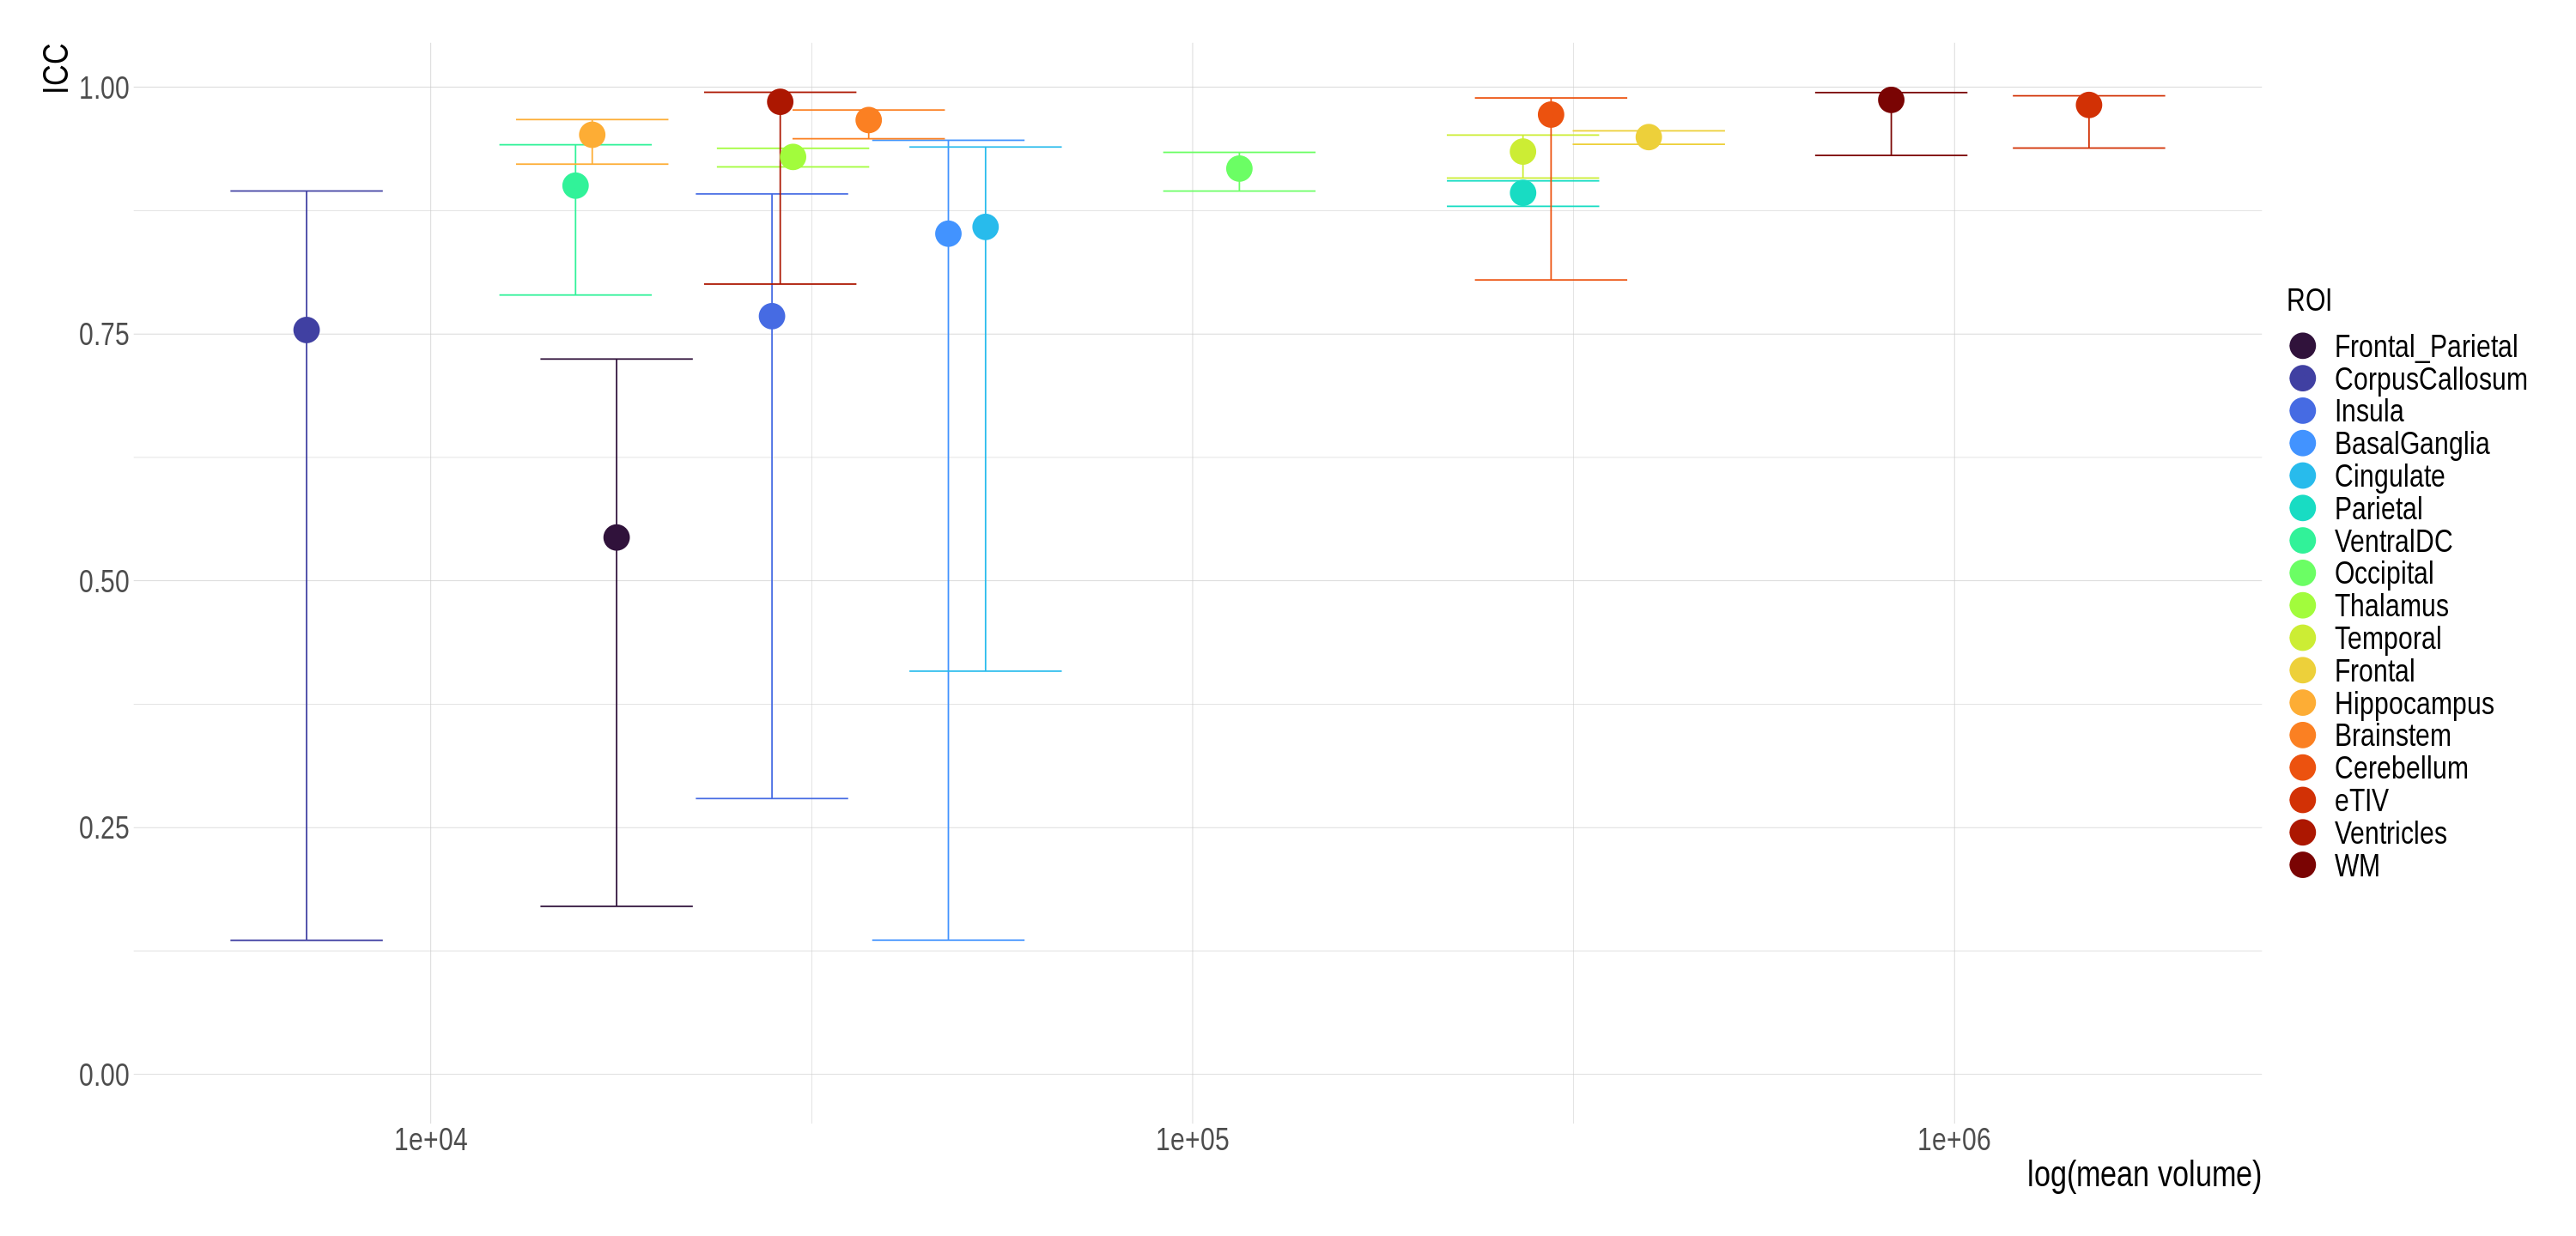

In [140]:
confidence_level <- 0.9  # Set your desired confidence level here

data %>%
  group_by(ROI) %>%
  summarize(
    agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$value,
    mean_vol = mean((vol_fast + vol_free) / 2, na.rm = TRUE),
    lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$lbound,
    uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$ubound
  ) %>%
  gather(key = 'key', value = 'icc', -c(mean_vol, ROI, lCI, uCI)) %>%
  arrange(icc) %>%
  mutate(ROI = fct_reorder(ROI, icc)) %>%

  mutate(labels = ifelse(icc < 0.5, as.character(ROI), '')) %>%
  ggplot(aes(x = mean_vol, y = icc, ymin = lCI, ymax = uCI, label = labels, color = ROI)) +
  geom_errorbar(width = 0.2) +
  geom_point(size = 8) +
  geom_jitter(size = 1) +
  scale_x_continuous(trans = 'log10') +
  labs(x = 'log(mean volume)', y = 'ICC') +
  scale_color_viridis_d(option = "turbo") +
  theme_ipsum() +
  theme(
    axis.title.x = element_text(size = 25),
    axis.title.y = element_text(size = 25),
    strip.text = element_text(size = 22),
    axis.text.x = element_text(size = 22),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 22),
    legend.text = element_text(size = 22)
  ) +
  expand_limits(y = 0) 
    

In [192]:
data %>%
head

,IDs,ROI,vol_fast,vol_free
,<chr>,<chr>,<dbl>,<dbl>
1,sub-k10010,BasalGanglia,50400.0,52386.4
2,sub-k10010,Brainstem,38393.6,40273.8
3,sub-k10010,Cerebellum,304943.2,308272.4
4,sub-k10010,Cingulate,52509.2,57639.4
5,sub-k10010,CorpusCallosum,7070.6,7396.4
6,sub-k10010,eTIV,1599818.0,1591678.0


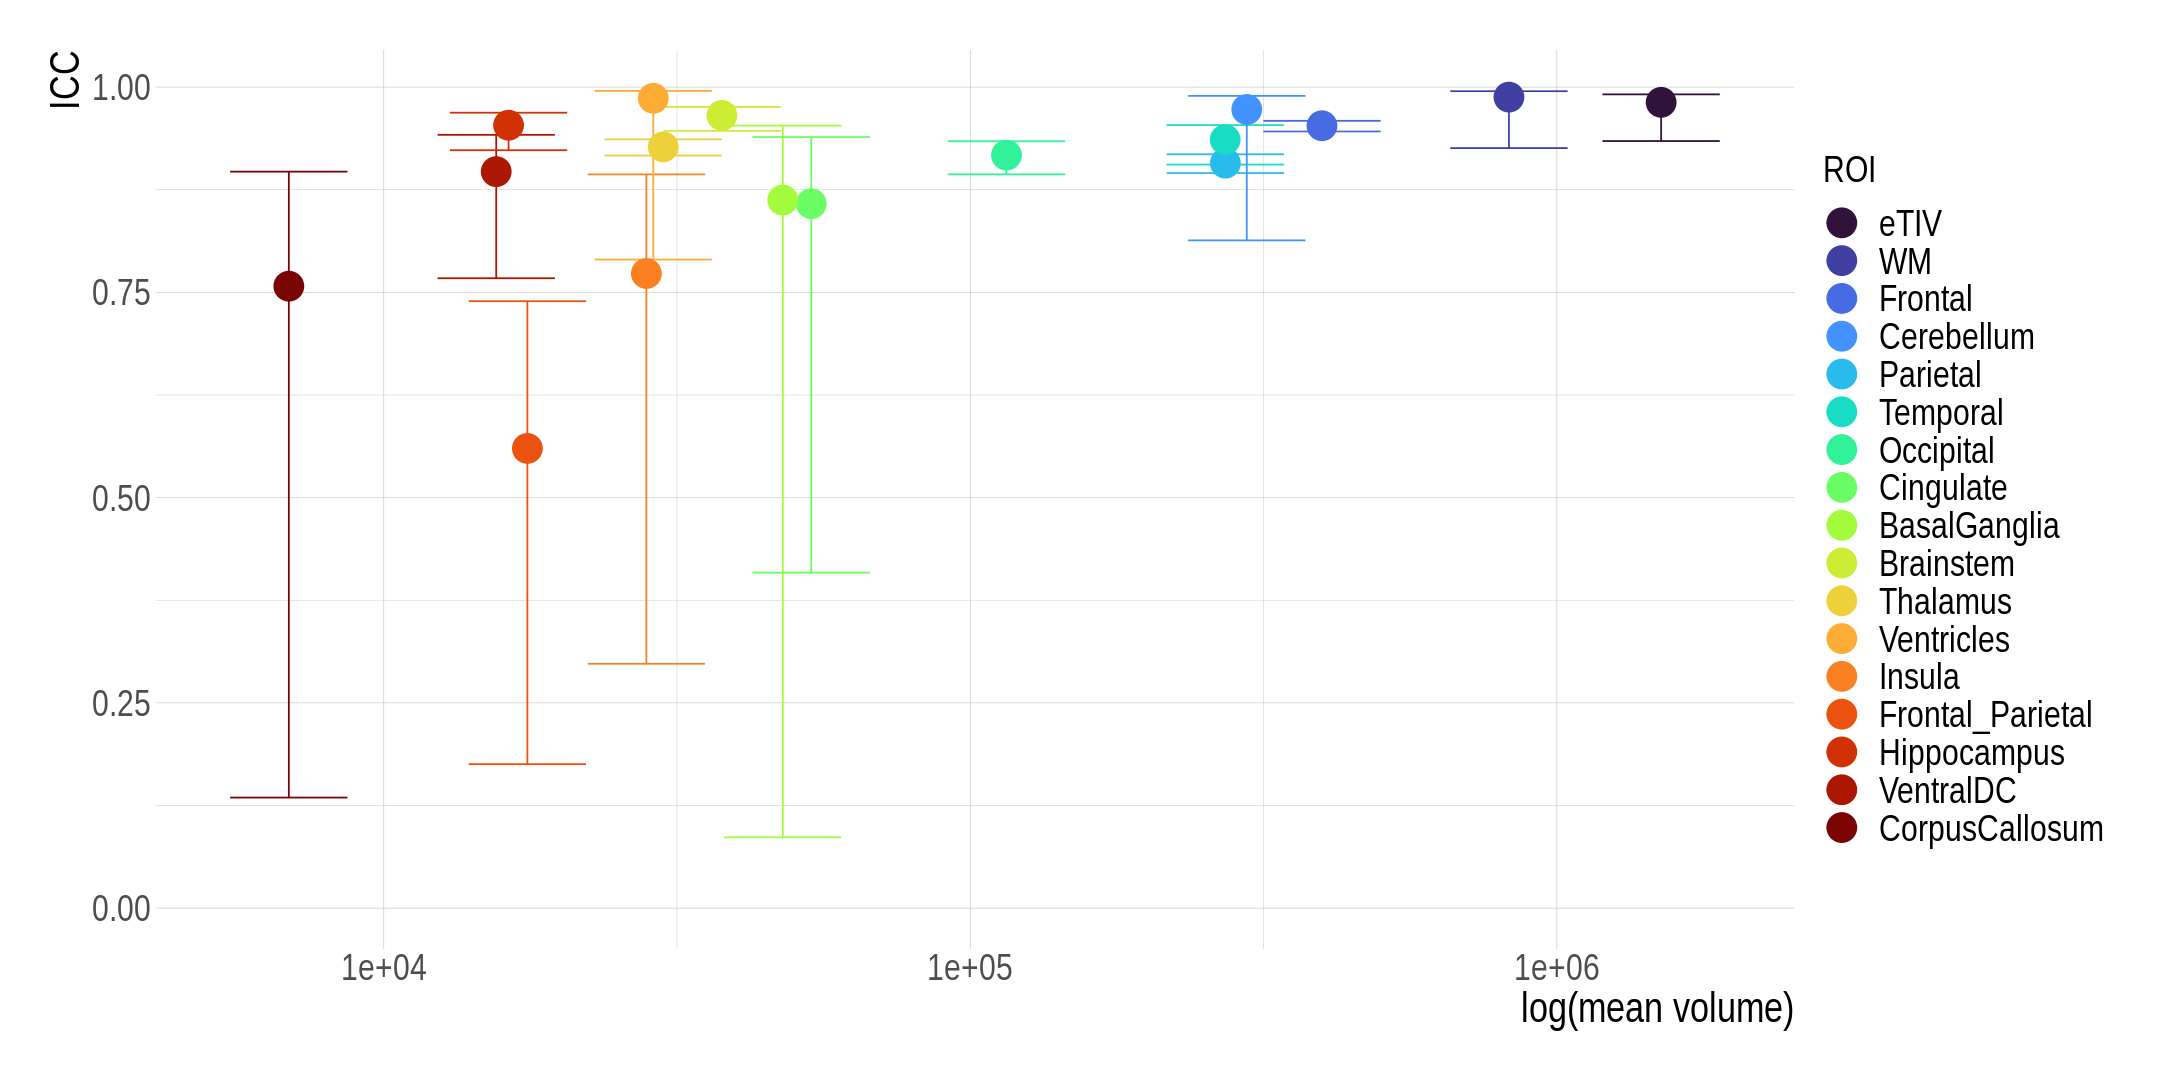

In [198]:
library(forcats)  # Load the forcats package if not already loaded

confidence_level <- 0.9  # Set your desired confidence level here

data %>%
  group_by(ROI) %>%
  summarize(
    agreement = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$value,
    mean_vol = mean((vol_fast + vol_free) / 2, na.rm = TRUE),
    lCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$lbound,
    uCI = icc(cbind(vol_fast, vol_free), "twoway", 'agreement', conf.level = confidence_level)$ubound
  ) %>%
  mutate(ROI = fct_reorder(ROI, -mean_vol)) %>%  # Reorder ROIs based on mean volume
  gather(key = 'key', value = 'icc', -c(mean_vol, ROI, lCI, uCI)) %>%
  arrange(icc) %>%
  mutate(labels = ifelse(icc < 0.5, as.character(ROI), '')) %>%
  ggplot(aes(x = mean_vol, y = icc, ymin = lCI, ymax = uCI, label = labels, color = ROI)) +
  geom_errorbar(width = 0.2) +
  geom_point(size = 8) +
  geom_jitter(size = 1) +
  scale_x_continuous(trans = 'log10') +
  labs(x = 'log(mean volume)', y = 'ICC') +
  scale_color_viridis_d(option = "turbo") +
  theme_ipsum() +
  theme(
    axis.title.x = element_text(size = 25),
    axis.title.y = element_text(size = 25),
    strip.text = element_text(size = 22),
    axis.text.x = element_text(size = 22),
    axis.text.y = element_text(size = 22),
    legend.title = element_text(size = 22),
    legend.text = element_text(size = 22)
  ) +
  expand_limits(y = 0) 


In [191]:
ggsave("/home/ibrazug/Dokumente/KindersegV2/Graphs/plot.jpeg", plot = last_plot(), width = 18, height = 9, dpi = 300)